# "You Snooze, You Win" Challenge

Every year, the [PhysioNet/CinC (Computing in Cardiology) Challenge](https://www.physionet.org/challenge/) invites "participants to tackle clinically interesting problems that are either unsolved or not well-solved." For this year's week 2 machine learning challenge, BWSI has revived a past PhysioNet challenge based on sleep classification.

This year's challenge focuses on the classification of nonarousal and arousal timeframes. If you would like to understand the biological implications of the challenge, we recommend reading PhysioNet's [introduction](https://physionet.org/challenge/2018/) of the challenge.

For this challenge, you will classify samples into 5 classes (Arousal, NREM1, NREM2, NREM3, REM). Each sample consists of seven physiological signals (O2-M1, E1-M2, Chin1-Chin2, ABD, CHEST, AIRFLOW, ECG) measured at 200 Hz over a 60 second period (12000 timepoints). In this notebook, we provide code to import the data, visualize sample signals, implement an example classifier, and 'score' your model.

In [ ]:
### Import libraries ###
# from google.colab import files
import matplotlib.pyplot as plt
import matplotlib

#set default plotting fonts
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import numpy as np
import os
import pandas as pd
import random
from sklearn import metrics
from sklearn.utils import shuffle

#data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#garbage collection (for saving RAM during training)
import gc


## Loading the Dataset

This dataset is a modified version of the PhysioNet/CinC Challenge data, which were contributed by the Massachusetts General Hospital’s Computational Clinical Neurophysiology Laboratory, and the Clinical Data Animation Laboratory.
***
**Class labels:**
- 0 = Arousal
- 1 = NREM1
- 2 = NREM2
- 3 = NREM3
- 4 = REM
***
**Class descriptions:**

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/blob/master/Images/Week2/sleepStagesTable.svg?raw=true">

***
**Physiological signal description:**

O2-M1 - posterior brain activity (electroencephalography)

E1-M2 - left eye activity (electrooculography)

Chin1-Chin2 - chin movement (electromyography)

ABD - abdominal movement (electromyography)

CHEST - chest movement (electromyography)

AIRFLOW - respiratory airflow

ECG - cardiac activity (electrocardiography)
***
Run both cell blocks to get the challenge data.

In [ ]:
# Clone repo and move into data directory (only run this once)
if not os.path.exists("./Data_Public/ChallengeProjects/Week2/"):
    os.system("git clone https://github.com/BeaverWorksMedlytics2020/Data_Public")
os.chdir("./Data_Public/ChallengeProjects/Week2/")


## Loading Data in Memory
Run the cell below to extract the raw training and test data. It may take a minute or two to run through. Here are the variables containing the data you will get:

* **data_train**: np array shape (4000, 12000, 7). Contains 4000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals.
* **labels_train**: np array shape (4000,). Contains ground truth labels for data_train. The order of the labels corresponds to the order of the training data.
* **ID_train**: list of 4000 unique IDs. The order of the IDs corresponds to the order of the training data.
* **data_test**: np array shape (1000, 12000, 7). Contains 1000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals.
* **ID_test**: list of 1000 unique IDs. The order of the IDs corresponds to the order of the training data.

We encourage you to print each of these variables to see what they look like.

In [ ]:
### Run once to import data ###

def get_file_locs():
    '''
    find all files in 'training' and 'test' directories and put their names
    under 'training' and 'test' keys in the file_dict dictionary
    '''

    file_dict = {'training':[], 'test':[]}
    for data_type in file_dict:
        for file in os.listdir('./' + data_type):
            file_dict[data_type].append(data_type + '/' + file)

    return file_dict

def get_sample_data(data_type, id_number):
    '''
    get signal data, label, and filename associated with given data type and index num

    parameters:

     data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

     id_number -- Which sample ID should be returned? Must be 0-3999 if data_type is 'training'
                 or 0-999 if data_type is 'test' (defaults to random integer from 0-999)

    returns:

     sample_data -- dataframe with 1 row and 2 columns-- column "Signal" contains a series object
                    and column "Label" contains numeric label for that sample
    '''
    file = './' + data_type + '/' + str(id_number) + '.xz'

    #sample_data is a dataframe with 1 row and 2 columns--
    #"Signal" (contains a series object) and "Label" (contains numeric label)
    sample_data = pd.read_pickle('./' + file)

    return sample_data, file.split('/')[2]

file_dict = get_file_locs()
print(f"{len(file_dict['training'])} training samples found, {len(file_dict['test'])} test samples found")

data_train = np.zeros((4000, 12000, 7))
labels_train = np.zeros(4000)
ID_train = []
for i in range(4000):
  sample_data, ID = get_sample_data('training', i)
  data_train[i] = np.array(list(sample_data['Signal']), dtype=float).reshape(12000, 7)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
  ID_train.append(ID)
  if(i%500==0):
    print('Loading training sample ' + str(i))

data_test = np.zeros((1000, 12000, 7))
ID_test = []
for i in range(1000):
  sample_data, ID = get_sample_data('test', i)
  data_test[i] = np.array(list(sample_data['Signal']), dtype=float).reshape(12000, 7)
  ID_test.append(ID)
  if(i%500==0):
    print('Loading test sample ' + str(i))

4000 training samples found, 1000 test samples found
Loading training sample 0


/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 500


/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 1000


/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 1500


/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 2000


/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 2500


/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 3000


/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 3500


/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-3-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading test sample 0
Loading test sample 500


##Processing labels


In [ ]:
### Create label array for all training samples using categorical datatype ###
train_labels = np.ndarray(shape = (1, 4000))

#set labels to integers first
for i in range(4000):
    train_labels[0][i] = i//800 # This is a way to label each entry (since classes are in order)


## Shuffle and Partition

In [ ]:
### Shuffle and partition all train data

#(Training data is ordered by default so shuffling before partitioning is important)

#--Shuffle data_train--
#(Note that data is only shuffled in first dimension, which is what we want)
shuffled_idx = np.random.permutation(len(data_train))
data_train = data_train[shuffled_idx]
train_labels = train_labels.squeeze(axis=0)
train_labels = train_labels[shuffled_idx]
#--Scale all labeled data in data_train--

#initialize standard scaler
scaler = StandardScaler()

#Standard scaler is meant for 2D arrays, so we reshape, scale, and then reshape again
reshaped_X_train = data_train.reshape((data_train.shape[0]*data_train.shape[1], data_train.shape[2])).copy()
reshaped_X_train = scaler.fit_transform(reshaped_X_train)
data_train = reshaped_X_train.reshape((data_train.shape[0], data_train.shape[1], data_train.shape[2]))

del reshaped_X_train #get rid of large temporary variable

#--Scale unlabeled test data--
#Because we scaled labeled data before training, we need to also scale test data --

#Standard scaler is meant for 2D arrays, so we reshape, apply scaling, and then
#reshape again to get back to original
reshaped_X_test = data_test.reshape((data_test.shape[0]*data_test.shape[1], data_test.shape[2])).copy()
reshaped_X_test = scaler.transform(reshaped_X_test)
data_test = reshaped_X_test.reshape((data_test.shape[0], data_test.shape[1], data_test.shape[2]))

del reshaped_X_test #get rid of large temporary variable

# need to reshape to (n, c, l)
data_train = data_train.transpose((0,2,1))
data_test = data_test.transpose((0,2,1))

In [ ]:
#--create 3 partitions of provided training data--
# Note we are breaking up provided labeled data into training, validation, and "mock test" sets

val_size = 1000
mocktest_size = 500

X_test = data_train[0:mocktest_size, :, :]
y_test = train_labels[0:mocktest_size]

X_val = data_train[mocktest_size:mocktest_size+val_size, :, :]
y_val = train_labels[mocktest_size:mocktest_size+val_size]

X_tr = data_train[mocktest_size+val_size:,:,:]
y_tr = train_labels[mocktest_size+val_size:]

del data_train
del train_labels

### Implement your model here

Feel free to use whatever architecture you want so long as it incorporates convolutions.

In [ ]:
# TODO: replace me with something else
#       just an example, feel free to go crazy

import torch
import torch.nn as nn

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

model = nn.Sequential(
    nn.Conv1d(7, 8, 9),
    nn.ReLU(),
    nn.MaxPool1d(8),
    nn.BatchNorm1d(8),

    nn.Conv1d(8, 16, 7),
    nn.ReLU(),
    nn.MaxPool1d(16),
    nn.BatchNorm1d(16),
    nn.Dropout(0.3),

    nn.Conv1d(16, 32, 5),
    nn.ReLU(),
    nn.MaxPool1d(32),
    nn.BatchNorm1d(32),
    nn.Dropout(0.3),

    nn.Flatten(),
    nn.Linear(64, 5)
)


In [ ]:
import torch
import torch.optim as optim

epochs = 26
batch_size = 600

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train = torch.utils.data.TensorDataset(
    torch.tensor(X_tr, dtype=torch.float32),
    torch.tensor(y_tr, dtype=torch.long)
)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        # Train loop
        model.train()
        inputs, labels = data

        # Pytorch keeps track of gradients across loops, so we need to zero it for each batch
        # We need to manually zero the gradient--reset it--every batch
        optimizer.zero_grad()

        outputs = model(inputs) # Get the model's output
        loss = criterion(outputs, labels) # Compute the loss
        preds = torch.argmax(outputs,dim=1)

        # For monitoring
        tr_loss = loss.item()
        tr_acc = torch.sum(preds==labels)/len(labels)

        loss.backward() # Backpropagate to compute gradient
        optimizer.step() # Update the parameters, according to chosen optimizer algorithm
    # Validation loop
    model.eval()
    inputs, labels = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)

    outputs = model(inputs)
    preds = torch.argmax(outputs,dim=1)

    val_loss = criterion(outputs, labels).item()
    val_acc = torch.sum(preds==labels)/len(labels)

    inputs, labels = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)
    outputs = model(inputs)
    preds = torch.argmax(outputs,dim=1)

    test_loss = criterion(outputs, labels).item()
    test_acc = torch.sum(preds==labels)/len(labels)


    print(
        ('Epoch #%d\t Training Loss: %.2f\tTraining Accuracy: %.2f\t''Validation Loss: %.2f\tValidation Accuracy: %.2f\t''Test Loss: %.2f\tTest Accuracy: %.2f')
         % (epoch + 1, tr_loss, tr_acc,
         val_loss, val_acc,  test_loss, test_acc))

Epoch #1	 Training Loss: 1.63	Training Accuracy: 0.30	Validation Loss: 1.57	Validation Accuracy: 0.32	Test Loss: 1.59	Test Accuracy: 0.28
Epoch #2	 Training Loss: 1.37	Training Accuracy: 0.44	Validation Loss: 1.47	Validation Accuracy: 0.43	Test Loss: 1.49	Test Accuracy: 0.37
Epoch #3	 Training Loss: 1.17	Training Accuracy: 0.54	Validation Loss: 1.39	Validation Accuracy: 0.41	Test Loss: 1.44	Test Accuracy: 0.38
Epoch #4	 Training Loss: 1.17	Training Accuracy: 0.49	Validation Loss: 1.37	Validation Accuracy: 0.45	Test Loss: 1.38	Test Accuracy: 0.42
Epoch #5	 Training Loss: 1.04	Training Accuracy: 0.55	Validation Loss: 1.26	Validation Accuracy: 0.53	Test Loss: 1.27	Test Accuracy: 0.45
Epoch #6	 Training Loss: 0.99	Training Accuracy: 0.59	Validation Loss: 1.20	Validation Accuracy: 0.55	Test Loss: 1.17	Test Accuracy: 0.53
Epoch #7	 Training Loss: 1.01	Training Accuracy: 0.63	Validation Loss: 1.13	Validation Accuracy: 0.56	Test Loss: 1.13	Test Accuracy: 0.53
Epoch #8	 Training Loss: 0.93	Trai

KeyboardInterrupt: 

In [ ]:
### Run once after you have finished training your model ###
#Reminder: Please ensure order of test data points has not been changed.
from google.colab import files
#-- Evaluate model for test data --
model.eval()
test_output = model(torch.tensor(data_test, dtype=torch.float32))
test_pred = torch.argmax(test_output, dim=1).detach().numpy()

file_path = '../../../test_pred.pickle'

import pickle
with open(file_path, 'wb') as f:
    pickle.dump(test_pred, f)

files.download('../../../test_pred.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(os.path.abspath(file_path))

/content/test_pred.pickle


## Submitting Your Model

After training your classifier, run it on the test data to generate your predictions. Each class for a test sample should have an associated probability (between 0 and 1). Below are the parameters for the prediction format and export:

- Your predictions should be in a pandas dataframe with 5 columns (classes) and 1000 rows (samples). Note that your predictions must follow the original test sample order (0.xz, 1.xz, 2.xz, ...). You only need to worry about this if you shuffled the test samples or stored the samples in an unordered data structure (dictionaries and sets). If this is the case, you should 1) add a separate column in your pandas dataframe with the file number for each sample; 2) sort the dataframe using this column; and 3) drop the column. These steps have been noted in the code below.
- The predictions dataframe should be exported as an .xz file using dataframe.to_pickle() followed by files.download().

Example code of the prediction format and export is presented in the cell block below.

Your model will be evaluated on Area Under the ROC Curve (ROCAUC), Matthews Correlation Coefficient (MCC) and creativity.

If you are finished early, consider trying other ML algorithms and/or implementing multiple feature extraction methods. You can also help other groups if you finish early.

## How Your Model Will Be Evaluated

- **Area Under the ROC Curve (AUCROC)**: The receiver operating characteristic (ROC) curve plots the true positive rate (sensitivity/recall) against the false positive rate (fall-out) at many decision threshold settings. The area under the curve (AUC) measures discrimination, the classifier's ability to correctly identify samples from the "positive" and "negative" cases. Intuitively, AUC is the probability that a randomly chosen "positive" sample will be labeled as "more positive" than a randomly chosen "negative" sample. In the case of a multi-class ROC curve, each class is considered separately before taking the weighted average of all the class results. Simply put, the class under consideration is labeled as "positive" while all other classes are labeled as "negative." Below is the multi-class ROC curve for the example classifier. The AUCROC score should be between 0 and 1, in which 0.5 is random classification and 1 is perfect classification.

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/blob/master/Images/Week2/MultiClassRocCurve_exampleClassifier.png?raw=true" width="600" height="500">

- **Matthews Correlation Coefficient (MCC)**: The MCC measures the quality of binary classifications, irrespective of the class sizes. Importantly, it is typically regarded as a balanced measure since it considers all values in the 2x2 contingency table (TP, FP, TN, FN). For this challenge, the binary classes will be "Arousal" (Arousal) and "Nonarousal" (NREM1, NREM2, NREM3, REM). The MCC score should be between -1 and 1, in which 0 is random classification and 1 is perfect classification.

 ![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5caa90fc15105b74b59a30bbc9cc2e5bd43a13b7)

Using these metrics, the example classifier has the following scores on test data:
- AUCROC: 0.727
- MCC: 0.163
- Creativity: ( ͡° ͜ʖ ͡°)

Below is the code used to calculate the AUCROC and MCC metrics when evaluating your classifier.

In [ ]:
model.eval()
test_pred = pd.DataFrame(model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy())
test_predict = test_pred.idxmax(axis=1)
test_labels = y_test.astype(int)
test_labels_one_hot = pd.DataFrame(np.eye(5)[test_labels])

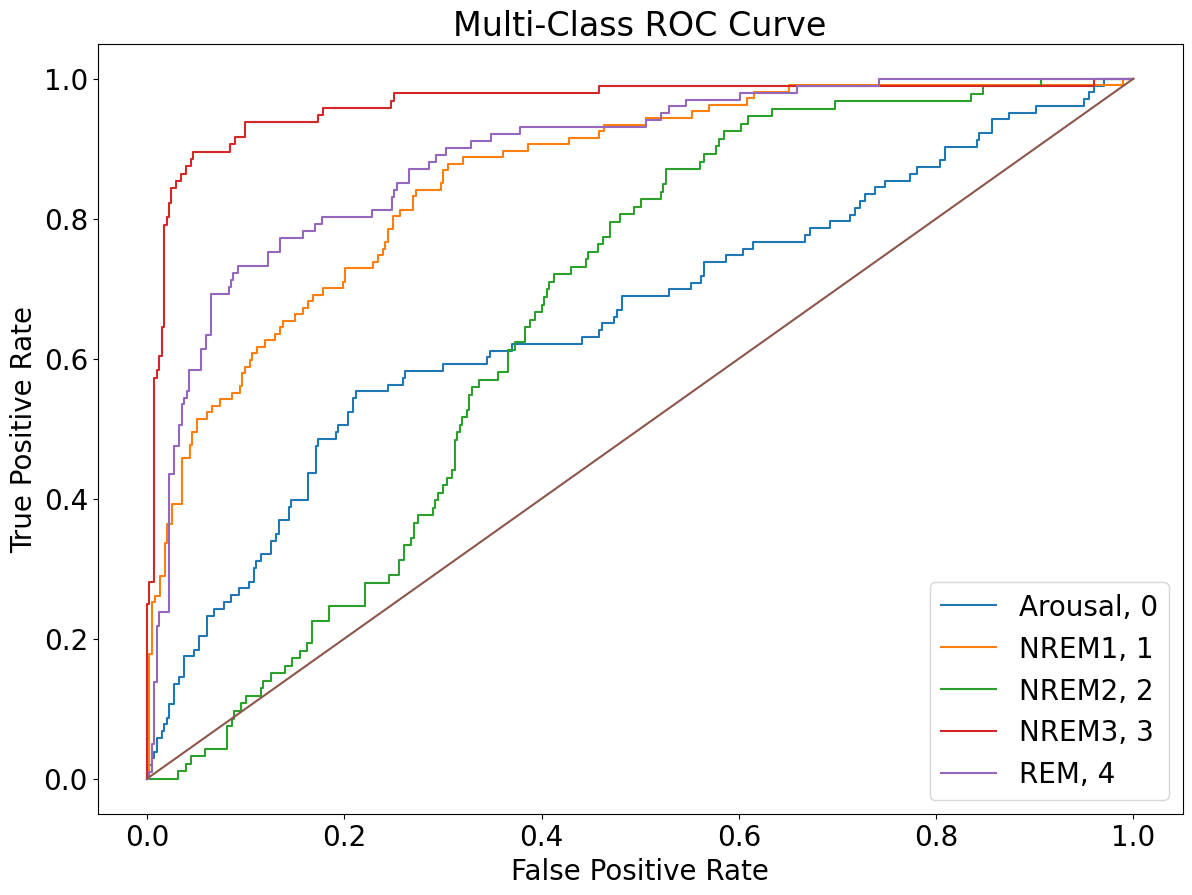

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

""" Initalize key reference dictionaries """
sig_dict = {0:'O2-M1', 1:'E1-M2', 2:'Chin1-Chin2', 3:'ABD', 4:'CHEST', 5:'AIRFLOW', 6:'ECG'}
sig_type_dict = {0:'Time (s)', 1:'Frequency (Hz)'}
stage_dict = {0:'Arousal', 1:'NREM1', 2:'NREM2', 3:'NREM3', 4:'REM'}

plt.figure(figsize=(14,10))
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels_one_hot.iloc[:, i], test_pred.iloc[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))

plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels_one_hot.values.ravel(), test_pred.values.ravel())
roc_auc_agg = metrics.auc(fpr["micro"], tpr["micro"])

In [ ]:
y_true = []
y_pred = []
for i in range(test_pred.shape[0]):
    if test_predict.iloc[i]==0: y_pred.append(1)
    else: y_pred.append(-1)
    if test_labels[i]==0: y_true.append(1)
    else: y_true.append(-1)
mcc = metrics.matthews_corrcoef(y_true, y_pred)

In [ ]:
print(roc_auc_agg, mcc)

0.812193 0.2200729449481684
